# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Univariate normal


## Generate data

In [4]:
from scipy.stats import norm

data = norm(10, 2).rvs(20)
data

array([ 9.19413254,  7.93174418,  9.26052972, 11.09719199,  8.40716297,
       10.28738107,  9.40427944,  7.29124596,  9.94310494, 10.34056147,
        8.25335541,  9.52849993,  8.49452561, 11.50807398,  9.39053403,
        8.14435859, 15.22433046,  6.37571855, 13.72639858,  9.00185182])

In [5]:
n = len(data)
xbar = np.mean(data)
s2 = np.var(data)

n, xbar, s2

(20, 9.640249062837732, 4.073028457273443)

## Grid algorithm

In [6]:
mus = np.linspace(8, 12, 101)
prior_mu = Pmf(1, mus)
prior_mu.index.name = 'mu'

In [7]:
sigmas = np.linspace(0.01, 5, 100)
ps = sigmas**-2
prior_sigma = Pmf(ps, sigmas)
prior_sigma.index.name = 'sigma'

In [8]:
from utils import make_joint

prior = make_joint(prior_mu, prior_sigma)

In [9]:
from utils import normalize

def update_norm(prior, data):
    """Update the prior based on data.
    
    prior: joint distribution of mu and sigma
    data: sequence of observations
    """
    X, Y, Z = np.meshgrid(prior.columns, prior.index, data)
    likelihood = norm(X, Y).pdf(Z).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [10]:
posterior = update_norm(prior, data)

In [11]:
from utils import marginal

posterior_mu_grid = marginal(posterior, 0)
posterior_sigma_grid = marginal(posterior, 1)

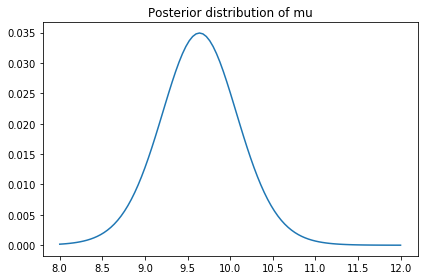

In [12]:
posterior_mu_grid.plot()
decorate(title='Posterior distribution of mu')

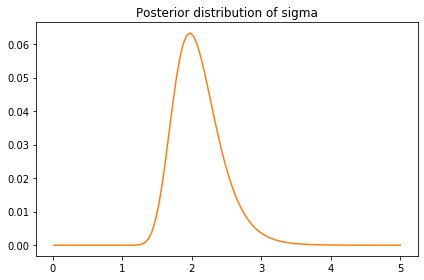

In [13]:
posterior_sigma_grid.plot(color='C1')
decorate(title='Posterior distribution of sigma')

## Update

Mostly following notation in Murphy, [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

In [14]:
m0 = 0
kappa0 = 0
alpha0 = 0
beta0 = 0

In [15]:
m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
m_n

9.640249062837732

In [16]:
kappa_n = kappa0 + n
kappa_n

20

In [17]:
alpha_n = alpha0 + n/2
alpha_n

10.0

In [18]:
beta_n = beta0 + n*s2/2 + n * kappa0 * (xbar-m0)**2 / (kappa0 + n)  / 2
beta_n

40.73028457273443

In [19]:
def update_normal(prior, summary):
    m0, kappa0, alpha0, beta0 = prior
    n, xbar, s2 = summary

    m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
    kappa_n = kappa0 + n
    alpha_n = alpha0 + n/2
    beta_n = (beta0 + n*s2/2 + 
              n * kappa0 * (xbar-m0)**2 / (kappa0 + n) / 2)

    return m_n, kappa_n, alpha_n, beta_n

In [20]:
prior = 0, 0, 0, 0
summary = n, xbar, s2
update_normal(prior, summary)

(9.640249062837732, 20, 10.0, 40.73028457273443)

## Posterior distribution of sigma

In [21]:
from scipy.stats import invgamma

dist_sigma2 = invgamma(alpha_n, scale=beta_n)

In [22]:
dist_sigma2.mean()

4.52558717474827

In [23]:
dist_sigma2.std()

1.6000366900576855

In [24]:
sigma2s = np.linspace(0.01, 20, 101)
ps = dist_sigma2.pdf(sigma2s)
posterior_sigma2_invgammas = Pmf(ps, sigma2s)
posterior_sigma2_invgammas.normalize()

5.002242322922353

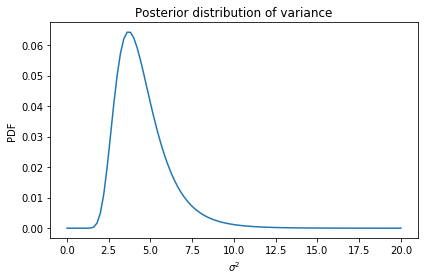

In [25]:
posterior_sigma2_invgammas.plot()
decorate(xlabel='$\sigma^2$',
         ylabel='PDF',
         title='Posterior distribution of variance')

In [26]:
sigmas = np.sqrt(sigma2s)
posterior_sigma_invgammas = Pmf(ps, sigmas)
posterior_sigma_invgammas.normalize()

5.002242322922353

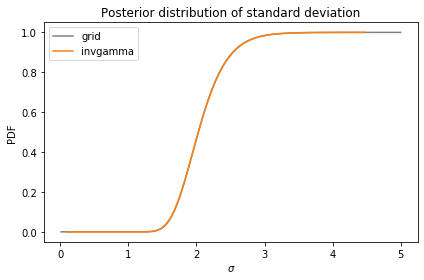

In [27]:
posterior_sigma_grid.make_cdf().plot(color='gray', label='grid')
posterior_sigma_invgammas.make_cdf().plot(color='C1', label='invgamma')

decorate(xlabel='$\sigma$',
         ylabel='PDF',
         title='Posterior distribution of standard deviation')

In [28]:
posterior_sigma_invgammas.mean(), posterior_sigma_grid.mean()

(2.0978773059173537, 2.0974647660359413)

In [29]:
posterior_sigma_invgammas.std(), posterior_sigma_grid.std()

(0.3514983795094244, 0.35127637938193573)

In [30]:
2 / np.sqrt(2 * (n-1))

0.3244428422615251

## Posterior distribution of mu

In [31]:
from scipy.stats import t as student_t

def make_student_t(df, loc, scale):
    return student_t(df, loc=loc, scale=scale)

In [32]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n
dist_mu = make_student_t(df, m_n, 1/np.sqrt(precision))

In [33]:
dist_mu.mean()

9.640249062837732

In [34]:
dist_mu.std()

0.47568829997952805

In [35]:
np.sqrt(4/n)

0.4472135954999579

In [36]:
mus = np.linspace(8, 12, 101)
ps = dist_mu.pdf(mus)
posterior_mu_student = Pmf(ps, mus)
posterior_mu_student.normalize()

24.980970615100787

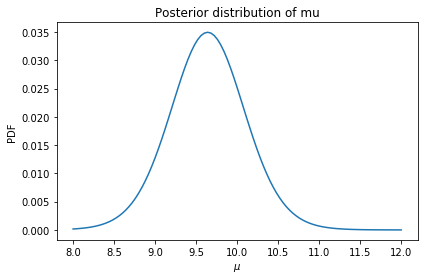

In [37]:
posterior_mu_student.plot()
decorate(xlabel='$\mu$',
         ylabel='PDF',
         title='Posterior distribution of mu')

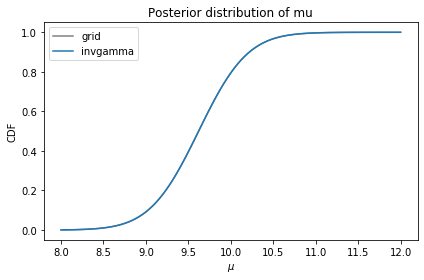

In [38]:
posterior_mu_grid.make_cdf().plot(color='gray', label='grid')
posterior_mu_student.make_cdf().plot(label='invgamma')
decorate(xlabel='$\mu$',
         ylabel='CDF',
         title='Posterior distribution of mu')

In [39]:
def make_posterior_mu(m_n, kappa_n, alpha_n, beta_n):
    df = 2 * alpha_n
    loc = m_n
    precision = alpha_n * kappa_n / beta_n
    dist_mu = make_student_t(df, loc, 1/np.sqrt(precision))
    return dist_mu

## Posterior joint distribution

In [40]:
mu_mesh, sigma2_mesh = np.meshgrid(mus, sigma2s)

In [41]:
joint = (dist_sigma2.pdf(sigma2_mesh) * 
         norm(m_n, sigma2_mesh/kappa_n).pdf(mu_mesh))
joint_df = pd.DataFrame(joint, columns=mus, index=sigma2s)

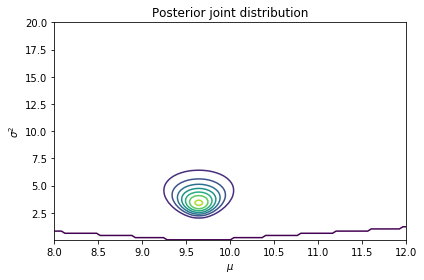

In [42]:
from utils import plot_contour

plot_contour(joint_df)
decorate(xlabel='$\mu$',
         ylabel='$\sigma^2$',
         title='Posterior joint distribution')

## Sampling from posterior predictive

In [43]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [44]:
sample_mu = norm(m_n, sample_sigma2 / kappa_n).rvs()

In [45]:
sample_pred = norm(sample_mu, np.sqrt(sample_sigma2)).rvs()

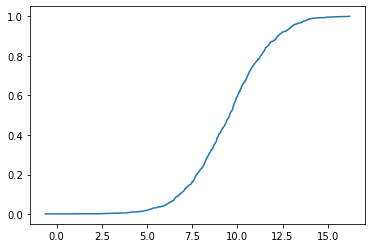

In [46]:
cdf_pred = Cdf.from_seq(sample_pred)
cdf_pred.plot()

In [47]:
sample_pred.mean(), sample_pred.var()

(9.516734504437707, 4.577270204875544)

## Analytic posterior predictive

In [48]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
dist_pred = make_student_t(df, m_n, 1/np.sqrt(precision))

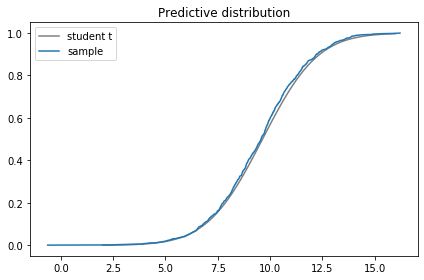

In [49]:
xs = np.linspace(2, 16, 101)
ys = dist_pred.cdf(xs)

plt.plot(xs, ys, color='gray', label='student t')
cdf_pred.plot(label='sample')

decorate(title='Predictive distribution')

In [50]:
def make_posterior_pred(m_n, kappa_n, alpha_n, beta_n):
    df = 2 * alpha_n
    loc = m_n
    precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
    dist_pred = make_student_t(df, loc, 1/np.sqrt(precision))
    return dist_pred

## Multivariate normal

## Generate data

In [51]:
mean = [10, 20]

sigma_x = 2
sigma_y = 3
rho = 0.3
cov = rho * sigma_x * sigma_y 

Sigma = [[sigma_x**2, cov], [cov, sigma_y**2]]
Sigma

[[4, 1.7999999999999998], [1.7999999999999998, 9]]

In [52]:
from scipy.stats import multivariate_normal

n = 20
data = multivariate_normal(mean, Sigma).rvs(n)
data

array([[ 9.09443543, 17.71994515],
       [16.44233547, 23.6472648 ],
       [12.01135574, 24.03660932],
       [ 9.0748985 , 21.66032914],
       [13.11185908, 18.83369963],
       [13.63682486, 21.49850919],
       [ 8.24152444, 22.92781604],
       [13.56010439, 29.07263218],
       [11.65768605, 20.22149536],
       [ 9.63956732, 16.85039916],
       [ 9.31995128, 15.62154768],
       [ 7.95094601, 14.22500863],
       [ 8.72949594, 20.7225257 ],
       [10.01041019, 21.53598675],
       [10.2989316 , 16.31756551],
       [ 7.95686713, 18.08908348],
       [ 6.84997664, 16.56372388],
       [ 8.88606479, 18.42782995],
       [10.0890154 , 21.17141536],
       [11.62347859, 17.63973527]])

In [53]:
n = len(data)
n

20

In [54]:
xbar = np.mean(data, axis=0)
xbar

array([10.40928644, 19.83915611])

In [55]:
S = np.cov(data.transpose())
S

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [56]:
np.corrcoef(data.transpose())

array([[1.        , 0.55681205],
       [0.55681205, 1.        ]])

In [57]:
stds = np.sqrt(np.diag(S))
stds

array([2.40367702, 3.51935735])

In [58]:
corrcoef = S / np.outer(stds, stds)
corrcoef

array([[1.        , 0.55681205],
       [0.55681205, 1.        ]])

In [59]:
def unpack_cov(S):
    stds = np.sqrt(np.diag(S))
    corrcoef = S / np.outer(stds, stds)
    return stds[0], stds[1], corrcoef[0][1]

In [60]:
sigma_x, sigma_y, rho = unpack_cov(S)
sigma_x, sigma_y, rho

(2.4036770231837497, 3.519357348098385, 0.5568120515289984)

In [61]:
def pack_cov(sigma_x, sigma_y, rho):
    cov = sigma_x * sigma_y * rho
    return np.array([[sigma_x**2, cov], [cov, sigma_y**2]])

In [62]:
pack_cov(sigma_x, sigma_y, rho)

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [63]:
S

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

## Update



In [64]:
m_0 = 0
Lambda_0 = 0
nu_0 = 0
kappa_0 = 0

In [65]:
m_n = (kappa_0 * m_0 + n * xbar) / (kappa_0 + n)
m_n

array([10.40928644, 19.83915611])

In [66]:
xbar

array([10.40928644, 19.83915611])

In [67]:
diff = (xbar - m_0)
D = np.outer(diff, diff)
D

array([[108.35324426, 206.51145873],
       [206.51145873, 393.59211512]])

In [68]:
Lambda_n = Lambda_0 + S + n * kappa_0 * D / (kappa_0 + n)
Lambda_n

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [69]:
S

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [70]:
nu_n = nu_0 + n
nu_n

20

In [71]:
kappa_n = kappa_0 + n
kappa_n

20

## Posterior distribution of covariance

In [72]:
from scipy.stats import invwishart

def make_invwishart(nu, Lambda):
    d, _ = Lambda.shape
    return invwishart(nu, scale=Lambda * (nu - d - 1))

In [73]:
dist_cov = make_invwishart(nu_n, Lambda_n)

In [74]:
dist_cov.mean()

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [75]:
S

array([[ 5.77766323,  4.71029497],
       [ 4.71029497, 12.38587614]])

In [76]:
sample_Sigma = dist_cov.rvs(1000)
np.mean(sample_Sigma, axis=0)

array([[ 5.75009385,  4.73096796],
       [ 4.73096796, 12.48177402]])

In [77]:
res = [unpack_cov(Sigma) for Sigma in sample_Sigma]

In [78]:
sample_sigma_x, sample_sigma_y, sample_rho = np.transpose(res)
sample_sigma_x.mean(), sample_sigma_y.mean(), sample_rho.mean()

(2.3607897260964137, 3.4767864662050987, 0.5480438257464233)

In [79]:
unpack_cov(S)

(2.4036770231837497, 3.519357348098385, 0.5568120515289984)

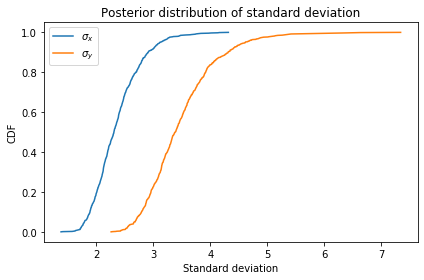

In [80]:
Cdf.from_seq(sample_sigma_x).plot(label=r'$\sigma_x$')
Cdf.from_seq(sample_sigma_y).plot(label=r'$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='CDF',
        title='Posterior distribution of standard deviation')

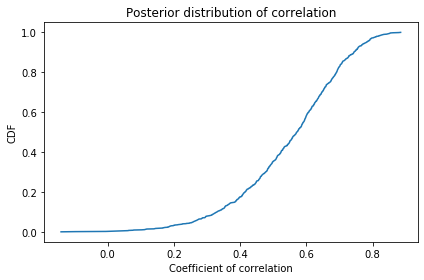

In [81]:
Cdf.from_seq(sample_rho).plot()

decorate(xlabel='Coefficient of correlation',
         ylabel='CDF',
         title='Posterior distribution of correlation')

## Evaluate the Inverse Wishart PDF

In [82]:
num = 51
sigma_xs = np.linspace(0.01, 10, num)

In [83]:
sigma_ys = np.linspace(0.01, 10, num)

In [84]:
rhos = np.linspace(-0.3, 0.9, num)

In [85]:
index = pd.MultiIndex.from_product([sigma_xs, sigma_ys, rhos],
                             names=['sigma_x', 'sigma_y', 'rho'])
joint = Pmf(0, index)
joint.head()

sigma_x  sigma_y  rho   
0.01     0.01     -0.300    0
                  -0.276    0
                  -0.252    0
                  -0.228    0
                  -0.204    0
dtype: int64

In [86]:
dist_cov.pdf(S)

0.006027909520828536

In [87]:
for sigma_x, sigma_y, rho in joint.index:
    Sigma = pack_cov(sigma_x, sigma_y, rho)
    joint.loc[sigma_x, sigma_y, rho] = dist_cov.pdf(Sigma)
    
joint.normalize()

4.700704063935837

In [88]:
from utils import pmf_marginal

posterior_sigma_x = pmf_marginal(joint, 0)
posterior_sigma_y = pmf_marginal(joint, 1)
marginal_rho = pmf_marginal(joint, 2)

posterior_sigma_x.mean(), posterior_sigma_y.mean(), marginal_rho.mean()

(2.210173131819553, 3.236037871074533, 0.5138102647160548)

In [89]:
unpack_cov(S)

(2.4036770231837497, 3.519357348098385, 0.5568120515289984)

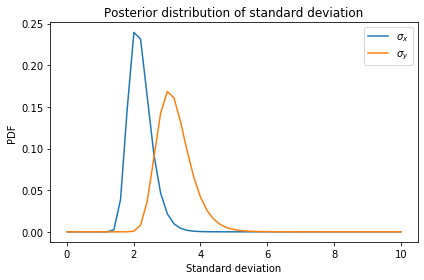

In [90]:
posterior_sigma_x.plot(label='$\sigma_x$')
posterior_sigma_y.plot(label='$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='PDF',
         title='Posterior distribution of standard deviation')

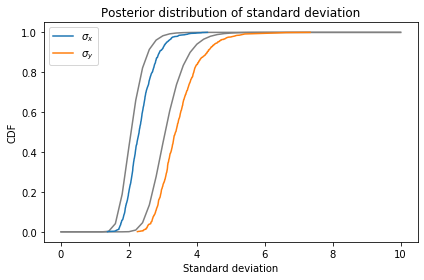

In [91]:
posterior_sigma_x.make_cdf().plot(color='gray')
posterior_sigma_y.make_cdf().plot(color='gray')

Cdf.from_seq(sample_sigma_x).plot(label=r'$\sigma_x$')
Cdf.from_seq(sample_sigma_y).plot(label=r'$\sigma_y$')

decorate(xlabel='Standard deviation',
         ylabel='CDF',
         title='Posterior distribution of standard deviation')

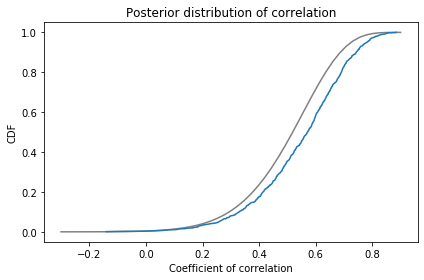

In [92]:
marginal_rho.make_cdf().plot(color='gray')

Cdf.from_seq(sample_rho).plot()

decorate(xlabel='Coefficient of correlation',
         ylabel='CDF',
         title='Posterior distribution of correlation')

## Posterior distribution of mu

In [93]:
m_n

array([10.40928644, 19.83915611])

In [94]:
sample_mu = [multivariate_normal(m_n, Sigma/kappa_n).rvs()
             for Sigma in sample_Sigma]

In [95]:
sample_mu0, sample_mu1 = np.transpose(sample_mu)

sample_mu0.mean(), sample_mu1.mean()

(10.417787293315167, 19.808873575990383)

In [96]:
xbar

array([10.40928644, 19.83915611])

In [97]:
sample_mu0.std(), sample_mu1.std()

(0.5383503263225001, 0.7858092840001913)

In [98]:
2 / np.sqrt(n), 3 / np.sqrt(n)

(0.4472135954999579, 0.6708203932499369)

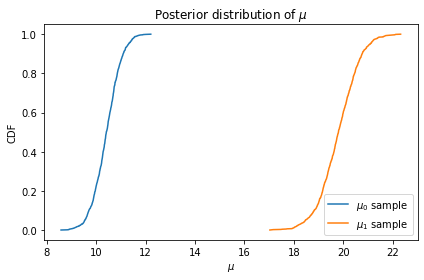

In [99]:
Cdf.from_seq(sample_mu0).plot(label=r'$\mu_0$ sample')
Cdf.from_seq(sample_mu1).plot(label=r'$\mu_1$ sample')

decorate(xlabel=r'$\mu$',
         ylabel='CDF',
         title=r'Posterior distribution of $\mu$')

## Multivariate student t

Let's use [this implementation](http://gregorygundersen.com/blog/2020/01/20/multivariate-t/)

In [100]:
from scipy.special import gammaln

def multistudent_pdf(x, mean, shape, df):
    return np.exp(logpdf(x, mean, shape, df))

def logpdf(x, mean, shape, df):
    p = len(mean)
    vals, vecs = np.linalg.eigh(shape)
    logdet     = np.log(vals).sum()
    valsinv    = np.array([1.0/v for v in vals])
    U          = vecs * np.sqrt(valsinv)
    dev        = x - mean
    maha       = np.square(dev @ U).sum(axis=-1)

    t = 0.5 * (df + p)
    A = gammaln(t)
    B = gammaln(0.5 * df)
    C = p/2. * np.log(df * np.pi)
    D = 0.5 * logdet
    E = -t * np.log(1 + (1./df) * maha)

    return A - B - C - D + E


In [101]:
d = len(m_n)
x = m_n
mean = m_n
df = nu_n - d + 1
shape = Lambda_n / kappa_n
multistudent_pdf(x, mean, shape, df)

0.4530003997972322

In [102]:
mu0s = np.linspace(8, 12, 91)
mu1s = np.linspace(18, 22, 101)

In [103]:
mu_mesh = np.dstack(np.meshgrid(mu0s, mu1s))
mu_mesh.shape

(101, 91, 2)

In [104]:
ps = multistudent_pdf(mu_mesh, mean, shape, df)

In [105]:
joint = pd.DataFrame(ps, columns=mu0s, index=mu1s)
normalize(joint)

549.2874162564223

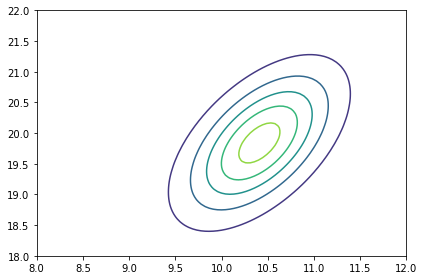

In [106]:
plot_contour(joint)

In [107]:
from utils import marginal

posterior_mu0_student = marginal(joint, 0)
posterior_mu1_student = marginal(joint, 1)

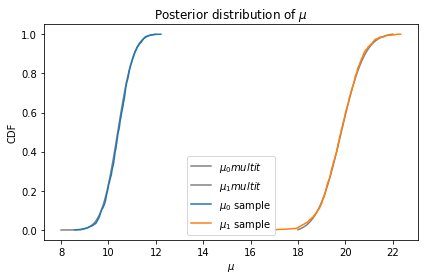

In [108]:
posterior_mu0_student.make_cdf().plot(color='gray', label=r'$\mu_0 multi t$')
posterior_mu1_student.make_cdf().plot(color='gray', label=r'$\mu_1 multi t$')

Cdf.from_seq(sample_mu0).plot(label=r'$\mu_0$ sample')
Cdf.from_seq(sample_mu1).plot(label=r'$\mu_1$ sample')

decorate(xlabel=r'$\mu$',
         ylabel='CDF',
         title=r'Posterior distribution of $\mu$')

## Compare to analytic univariate distributions

In [109]:
prior = 0, 0, 0, 0
summary = n, xbar[0], S[0][0]
summary

(20, 10.409286443363563, 5.777663231781492)

In [110]:
params = update_normal(prior, summary)
params

(10.409286443363563, 20, 10.0, 57.77663231781492)

In [111]:
dist_mu0 = make_posterior_mu(*params)
dist_mu0.mean(), dist_mu0.std()

(10.409286443363563, 0.5665521076251745)

In [112]:
mu0s = np.linspace(7, 12, 101)
ps = dist_mu0.pdf(mu0s)
posterior_mu0 = Pmf(ps, index=mu0s)
posterior_mu0.normalize()

19.930298060446894

In [113]:
prior = 0, 0, 0, 0
summary = n, xbar[1], S[1][1]
summary

(20, 19.839156108992704, 12.385876143614098)

In [114]:
params = update_normal(prior, summary)
params

(19.839156108992704, 20, 10.0, 123.85876143614098)

In [115]:
dist_mu1 = make_posterior_mu(*params)
dist_mu1.mean(), dist_mu1.std()

(19.839156108992704, 0.8295204820863575)

In [116]:
mu1s = np.linspace(17, 23, 101)
ps = dist_mu1.pdf(mu1s)
posterior_mu1 = Pmf(ps, index=mu1s)
posterior_mu1.normalize()

16.64813735166017

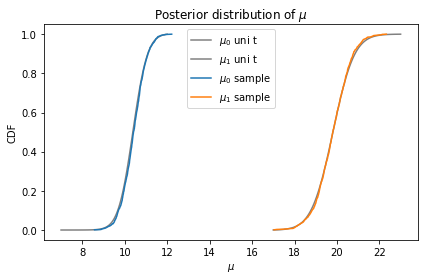

In [117]:
posterior_mu0.make_cdf().plot(label=r'$\mu_0$ uni t', color='gray')
posterior_mu1.make_cdf().plot(label=r'$\mu_1$ uni t', color='gray')

Cdf.from_seq(sample_mu0).plot(label=r'$\mu_0$ sample')
Cdf.from_seq(sample_mu1).plot(label=r'$\mu_1$ sample')

decorate(xlabel=r'$\mu$',
         ylabel='CDF',
         title=r'Posterior distribution of $\mu$')

## Sampling from posterior predictive

In [118]:
sample_pred = [multivariate_normal(mu, Sigma).rvs()
               for mu, Sigma in zip(sample_mu, sample_Sigma)]

In [119]:
sample_x0, sample_x1 = np.transpose(sample_pred)

sample_x0.mean(), sample_x1.mean()

(10.343334031620982, 19.79428758822268)

In [120]:
sample_x0.std(), sample_x1.std()

(2.4491840957223703, 3.5023208219780724)

In [121]:
prior = 0, 0, 0, 0
summary = n, xbar[0], S[0][0]
params = update_normal(prior, summary)
dist_x0 = make_posterior_pred(*params)
dist_x0.mean(), dist_x0.std()

(10.409286443363563, 2.5962679183291297)

In [122]:
x0s = np.linspace(2, 18, 101)
ps = dist_x0.pdf(x0s)
pred_x0 = Pmf(ps, index=x0s)
pred_x0.normalize()

6.224974183920316

In [123]:
prior = 0, 0, 0, 0
summary = n, xbar[1], S[1][1]
params = update_normal(prior, summary)
dist_x1 = make_posterior_pred(*params)
dist_x1.mean(), dist_x1.std()

(19.839156108992704, 3.8013403996769934)

In [124]:
x1s = np.linspace(10, 30, 101)
ps = dist_x1.pdf(x1s)
pred_x1 = Pmf(ps, index=x1s)
pred_x1.normalize()

4.944574125732073

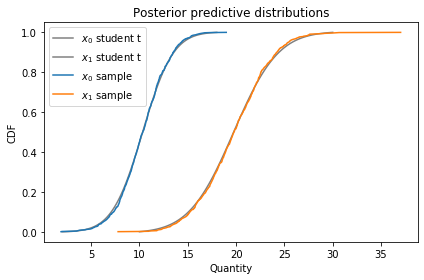

In [125]:
pred_x0.make_cdf().plot(label=r'$x_0$ student t', color='gray')
pred_x1.make_cdf().plot(label=r'$x_1$ student t', color='gray')

Cdf.from_seq(sample_x0).plot(label=r'$x_0$ sample')
Cdf.from_seq(sample_x1).plot(label=r'$x_1$ sample')

decorate(xlabel='Quantity',
         ylabel='CDF',
         title='Posterior predictive distributions')

## Comparing to the multivariate student t

In [126]:
d = len(m_n)
x = m_n
mean = m_n
df = nu_n - d + 1
shape = Lambda_n * (kappa_n+1) / kappa_n
multistudent_pdf(x, mean, shape, df)

0.02157144760939201

In [127]:
x0s = np.linspace(0, 20, 91)
x1s = np.linspace(10, 30, 101)

In [128]:
x_mesh = np.dstack(np.meshgrid(x0s, x1s))
x_mesh.shape

(101, 91, 2)

In [129]:
ps = multistudent_pdf(x_mesh, mean, shape, df)

In [130]:
joint = pd.DataFrame(ps, columns=x0s, index=x1s)
normalize(joint)

22.23349484051357

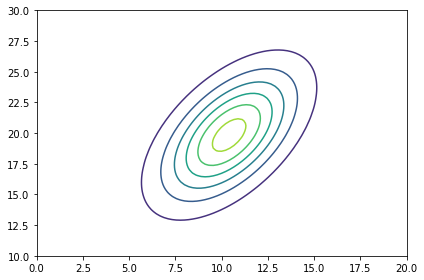

In [131]:
plot_contour(joint)

In [132]:
from utils import marginal

posterior_x0_student = marginal(joint, 0)
posterior_x1_student = marginal(joint, 1)

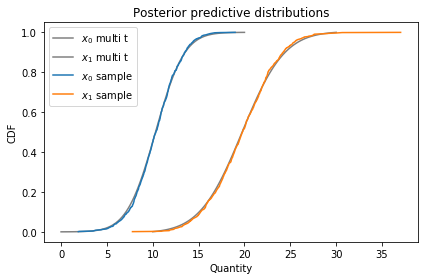

In [133]:
posterior_x0_student.make_cdf().plot(color='gray', label=r'$x_0$ multi t')
posterior_x1_student.make_cdf().plot(color='gray', label=r'$x_1$ multi t')

Cdf.from_seq(sample_x0).plot(label=r'$x_0$ sample')
Cdf.from_seq(sample_x1).plot(label=r'$x_1$ sample')

decorate(xlabel='Quantity',
         ylabel='CDF',
         title='Posterior predictive distributions')

## Bayesian linear regression

## Generate data

In [ ]:
inter, slope = 5, 2
sigma = 3
n = 20

In [ ]:
xs = norm(0, 3).rvs(n)
xs = np.sort(xs)
ys = inter + slope * xs + norm(0, sigma).rvs(20)

plt.plot(xs, ys, 'o');

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(xs)
X

In [ ]:
model = sm.OLS(ys, X)
results = model.fit()
results.summary()

In [ ]:
beta_hat = results.params
beta_hat

In [ ]:
# k = results.df_model
k = 2

In [ ]:
s2 = results.resid @ results.resid / (n - k)
s2

In [ ]:
s2 = results.ssr / (n - k)
s2

In [ ]:
np.sqrt(s2)

## Grid algorithm

In [ ]:
beta0s = np.linspace(2, 8, 71)
prior_inter = Pmf(1, beta0s, name='inter')
prior_inter.index.name = 'Intercept'

In [ ]:
beta1s = np.linspace(1, 3, 61)
prior_slope = Pmf(1, beta1s, name='slope')
prior_slope.index.name = 'Slope'

In [ ]:
sigmas = np.linspace(1, 6, 51)
ps = sigmas**-2
prior_sigma = Pmf(ps, sigmas, name='sigma')
prior_sigma.index.name = 'Sigma'
prior_sigma.normalize()

prior_sigma.plot()

In [ ]:
from utils import make_joint

def make_joint3(pmf1, pmf2, pmf3):
    """Make a joint distribution with three parameters.
    
    pmf1: Pmf object
    pmf2: Pmf object
    pmf3: Pmf object
    
    returns: Pmf representing a joint distribution
    """
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

In [ ]:
prior3 = make_joint3(prior_slope, prior_inter, prior_sigma)
prior3.head()

In [ ]:
from utils import normalize

def update_optimized(prior, data):
    """Posterior distribution of regression parameters
    `slope`, `inter`, and `sigma`.
    
    prior: Pmf representing the joint prior
    data: DataFrame with columns `x` and `y`
    
    returns: Pmf representing the joint posterior
    """
    xs = data['x']
    ys = data['y']
    sigmas = prior.columns
    likelihood = prior.copy()

    for slope, inter in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
        densities = norm.pdf(resid_mesh, 0, sigma_mesh)
        likelihood.loc[slope, inter] = densities.prod(axis=1)
        
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

In [ ]:
data = pd.DataFrame(dict(x=xs, y=ys))

In [ ]:
from utils import normalize

posterior = update_optimized(prior3.unstack(), data)
normalize(posterior)

In [ ]:
from utils import marginal

posterior_sigma_grid = marginal(posterior, 0)
posterior_sigma_grid.plot(label='grid')

decorate(title='Posterior distribution of sigma')

In [ ]:
joint_posterior = marginal(posterior, 1).unstack()
plot_contour(joint_posterior)

In [ ]:
posterior_beta0_grid = marginal(joint_posterior, 0)
posterior_beta1_grid = marginal(joint_posterior, 1)

In [ ]:
posterior_beta0_grid.make_cdf().plot(label=r'$\beta_0$')
posterior_beta1_grid.make_cdf().plot(label=r'$\beta_1$')

decorate(title='Posterior distributions of parameters')

## Posterior distribution of sigma

According to Gelman et al, the posterior distribution of $\sigma^2$ is scaled inverse chi2 with $\nu=n-k$ and scale $s^2$.

According to [Wikipedia](https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution), that's equivalent to inverse gamma with parameters $\nu/2$ and $\nu s^2 / 2$.

In [ ]:
nu = n-k
nu/2, nu*s2/2

In [ ]:
from scipy.stats import invgamma

dist_sigma2 = invgamma(nu/2, scale=nu*s2/2)
dist_sigma2.mean()

In [ ]:
sigma2s = np.linspace(0.01, 30, 101)
ps = dist_sigma2.pdf(sigma2s)
posterior_sigma2_invgamma = Pmf(ps, sigma2s)
posterior_sigma2_invgamma.normalize()

In [ ]:
posterior_sigma2_invgamma.plot()

In [ ]:
sigmas = np.sqrt(sigma2s)
posterior_sigma_invgamma = Pmf(ps, sigmas)
posterior_sigma_invgamma.normalize()

In [ ]:
posterior_sigma_invgamma.mean(), posterior_sigma_grid.mean()

In [ ]:
posterior_sigma_grid.make_cdf().plot(color='gray', label='grid')
posterior_sigma_invgamma.make_cdf().plot(label='invgamma')

decorate(title='Posterior distribution of sigma')

## Posterior distribution of sigma, updatable version

Per the Wikipedia page: https://en.wikipedia.org/wiki/Bayesian_linear_regression

In [ ]:
Lambda_0 = np.zeros((k, k))
Lambda_n = Lambda_0 + X.T @ X
Lambda_n

In [ ]:
from scipy.linalg import inv

mu_0 = np.zeros(k)
mu_n = inv(Lambda_n) @ (Lambda_0 @ mu_0 + X.T @ X @ beta_hat)
mu_n

In [ ]:
a_0 = 0
a_n = a_0 + n / 2
a_n

In [ ]:
b_0 = 0
b_n = b_0 + (ys.T @ ys + 
             mu_0.T @ Lambda_0 @ mu_0 - 
             mu_n.T @ Lambda_n @ mu_n) / 2
b_n

In [ ]:
a_n, nu/2

In [ ]:
b_n, nu * s2 / 2

## Sampling the posterior of the parameters

In [ ]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [ ]:
sample_sigma = np.sqrt(sample_sigma2)

In [ ]:
from scipy.linalg import inv

V_beta = inv(X.T @ X)
V_beta

In [ ]:
sample_beta = [multivariate_normal(beta_hat, V_beta * sigma2).rvs()
               for sigma2 in sample_sigma2]

In [ ]:
np.mean(sample_beta, axis=0)

In [ ]:
beta_hat

In [ ]:
np.std(sample_beta, axis=0)

In [ ]:
results.bse

In [ ]:
sample_beta0, sample_beta1 = np.transpose(sample_beta)

In [ ]:
Cdf.from_seq(sample_beta0).plot(label=r'$\beta_0$')
Cdf.from_seq(sample_beta1).plot(label=r'$\beta_1$')

decorate(title='Posterior distributions of the parameters')

## Posterior using multivariate Student t

In [ ]:
x = beta_hat
mean = beta_hat
df = (n - k)
shape = (V_beta * s2)
multistudent_pdf(x, mean, shape, df)

In [ ]:
low, high = sample_beta0.min(), sample_beta0.max()
low, high

In [ ]:
beta0s = np.linspace(0.9*low, 1.1*high, 101)

In [ ]:
low, high = sample_beta1.min(), sample_beta1.max()

In [ ]:
beta1s = np.linspace(0.9*low, 1.1*high, 91)

In [ ]:
beta0_mesh, beta1_mesh = np.meshgrid(beta0s, beta1s)

In [ ]:
beta_mesh = np.dstack(np.meshgrid(beta0s, beta1s))
beta_mesh.shape

In [ ]:
ps = multistudent_pdf(beta_mesh, mean, shape, df)
ps.shape

In [ ]:
joint = pd.DataFrame(ps, columns=beta0s, index=beta1s)

In [ ]:
from utils import normalize

normalize(joint)

In [ ]:
from utils import plot_contour

plot_contour(joint)
decorate(xlabel=r'$\beta_0$',
         ylabel=r'$\beta_1$')

In [ ]:
marginal_beta0_student = marginal(joint, 0)
marginal_beta1_student = marginal(joint, 1)

In [ ]:
from utils import marginal

posterior_beta0_grid.make_cdf().plot(color='gray', label=r'grid $\beta_0$')
posterior_beta1_grid.make_cdf().plot(color='gray', label=r'grid $\beta_1$')

marginal_beta0_student.make_cdf().plot(label=r'student $\beta_0$', color='gray')
marginal_beta1_student.make_cdf().plot(label=r'student $\beta_0$', color='gray')

Cdf.from_seq(sample_beta0).plot(label=r'sample $\beta_0$')
Cdf.from_seq(sample_beta1).plot(label=r'sample $\beta_1$')

decorate()

## Sampling the predictive distribution

In [ ]:
t = [X @ beta + norm(0, sigma).rvs(n)
     for beta, sigma in zip(sample_beta, sample_sigma)]
predictions = np.array(t)
predictions.shape

In [ ]:
low, median, high = np.percentile(predictions, [5, 50, 95], axis=0)

In [ ]:
plt.plot(xs, ys, 'o')
plt.plot(xs, median)
plt.fill_between(xs, low, high, color='C1', alpha=0.3)

## Modeling the predictive distribution

In [ ]:
xnew = [1, 2, 3]
Xnew = sm.add_constant(xnew)
Xnew

In [ ]:
t = [Xnew @ beta + norm(0, sigma).rvs(len(xnew))
     for beta, sigma in zip(sample_beta, sample_sigma)]
predictions = np.array(t)
predictions.shape

In [ ]:
x0, x1, x2 = predictions.T

Cdf.from_seq(x0).plot()
Cdf.from_seq(x1).plot()
Cdf.from_seq(x2).plot()

In [ ]:
mu_new = Xnew @ beta_hat
mu_new

In [ ]:
cov_new = s2 * (np.eye(len(xnew)) + Xnew @ V_beta @ Xnew.T)
cov_new

In [ ]:
x = mu_new
mean = mu_new
df = (n - k)
shape = cov_new
multistudent_pdf(x, mean, shape, df)

In [ ]:
y1s = np.linspace(0, 20, 51)
y0s = np.linspace(0, 20, 61)
y2s = np.linspace(0, 20, 71)

In [ ]:
mesh = np.stack(np.meshgrid(y0s, y1s, y2s), axis=-1)
mesh.shape

In [ ]:
ps = multistudent_pdf(mesh, mean, shape, df)
ps.shape

In [ ]:
ps /= ps.sum()
ps.sum()

In [ ]:
p1s = ps.sum(axis=1).sum(axis=1)
p1s.shape

In [ ]:
p0s = ps.sum(axis=0).sum(axis=1)
p0s.shape

In [ ]:
p2s = ps.sum(axis=0).sum(axis=0)
p2s.shape

In [ ]:
pmf_y0 = Pmf(p0s, y0s)
pmf_y1 = Pmf(p1s, y1s)
pmf_y2 = Pmf(p2s, y2s)

pmf_y0.mean(), pmf_y1.mean(), pmf_y2.mean()

In [ ]:
pmf_y0.make_cdf().plot(color='gray')
pmf_y1.make_cdf().plot(color='gray')
pmf_y2.make_cdf().plot(color='gray')

Cdf.from_seq(x0).plot()
Cdf.from_seq(x1).plot()
Cdf.from_seq(x2).plot()

In [ ]:
stop

## Leftovers

Related discussion saved for the future

https://stats.stackexchange.com/questions/78177/posterior-covariance-of-normal-inverse-wishart-not-converging-properly

In [ ]:
from scipy.stats import chi2


class NormalInverseWishartDistribution(object):
    def __init__(self, mu, lmbda, nu, psi):
        self.mu = mu
        self.lmbda = float(lmbda)
        self.nu = nu
        self.psi = psi
        self.inv_psi = np.linalg.inv(psi)

    def sample(self):
        sigma = np.linalg.inv(self.wishartrand())
        return (np.random.multivariate_normal(self.mu, sigma / self.lmbda), sigma)

    def wishartrand(self):
        dim = self.inv_psi.shape[0]
        chol = np.linalg.cholesky(self.inv_psi)
        foo = np.zeros((dim,dim))

        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    foo[i,j] = np.sqrt(chi2.rvs(self.nu-(i+1)+1))
                else:
                    foo[i,j]  = np.random.normal(0,1)
        return np.dot(chol, np.dot(foo, np.dot(foo.T, chol.T)))

    def posterior(self, data):
        n = len(data)
        mean_data = np.mean(data, axis=0)
        sum_squares = np.sum([np.array(np.matrix(x - mean_data).T * np.matrix(x - mean_data)) for x in data], axis=0)
        mu_n = (self.lmbda * self.mu + n * mean_data) / (self.lmbda + n)
        lmbda_n = self.lmbda + n
        nu_n = self.nu + n
        dev = mean_data - self.mu
        psi_n = (self.psi + sum_squares + 
                 self.lmbda * n / (self.lmbda + n) * np.array(dev.T @ dev))
        return NormalInverseWishartDistribution(mu_n, lmbda_n, nu_n, psi_n)

    

x = NormalInverseWishartDistribution(np.array([0,0])-3,1,3,np.eye(2))
samples = [x.sample() for _ in range(100)]
data = [np.random.multivariate_normal(mu,cov) for mu,cov in samples]
y = NormalInverseWishartDistribution(np.array([0,0]),1,3,np.eye(2))
z = y.posterior(data)

print('mu_n: {0}'.format(z.mu))

print('psi_n: {0}'.format(z.psi))

In [ ]:
from scipy.linalg import inv
from scipy.linalg import cholesky

def wishartrand(nu, Lambda):
    d, _ = Lambda.shape
    chol = cholesky(Lambda)
    foo = np.empty((d, d))

    for i in range(d):
        for j in range(i+1):
            if i == j:
                foo[i,j] = np.sqrt(chi2.rvs(nu-(i+1)+1))
            else:
                foo[i,j] = np.random.normal(0, 1)
                
    return np.dot(chol, np.dot(foo, np.dot(foo.T, chol.T)))

In [ ]:
sample = [wishartrand(nu_n, Lambda_n) for i in range(1000)]

In [ ]:
np.mean(sample, axis=0)

In [ ]:
Lambda_n